In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

df = pd.read_csv("chembl_pretraining.csv")
smiles_column = "smiles"

df["mol"] = df[smiles_column].apply(Chem.MolFromSmiles)

df = df[df["mol"].notna()].reset_index(drop=True)

generator = GetMorganGenerator(radius=3, fpSize=2048)
df["ecfp6"] = df["mol"].apply(generator.GetFingerprint)

n = len(df)
fps = list(df["ecfp6"])

# Create a memory-mapped array on disk
sim_matrix = np.memmap("tanimoto_sim_matrix.dat", dtype="float32", mode="w+", shape=(n, n))

for i in range(n):
    sims = DataStructs.BulkTanimotoSimilarity(fps[i], fps)
    sim_matrix[i, :] = sims
    if i % 1000 == 0:
        print(f"Processed row {i}/{n}")

Processed row 0/79492
Processed row 1000/79492
Processed row 2000/79492
Processed row 3000/79492
Processed row 4000/79492
Processed row 5000/79492
Processed row 6000/79492
Processed row 7000/79492
Processed row 8000/79492
Processed row 9000/79492
Processed row 10000/79492
Processed row 11000/79492
Processed row 12000/79492
Processed row 13000/79492
Processed row 14000/79492
Processed row 15000/79492
Processed row 16000/79492
Processed row 17000/79492
Processed row 18000/79492
Processed row 19000/79492
Processed row 20000/79492
Processed row 21000/79492
Processed row 22000/79492
Processed row 23000/79492
Processed row 24000/79492
Processed row 25000/79492
Processed row 26000/79492
Processed row 27000/79492
Processed row 28000/79492
Processed row 29000/79492
Processed row 30000/79492
Processed row 31000/79492
Processed row 32000/79492
Processed row 33000/79492
Processed row 34000/79492
Processed row 35000/79492
Processed row 36000/79492
Processed row 37000/79492
Processed row 38000/79492

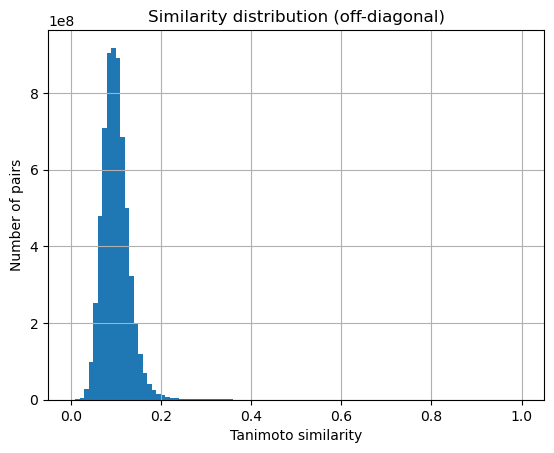

In [3]:
# Reload the similarity matrix
n = len(df)
sim_matrix = np.memmap("tanimoto_sim_matrix.dat", dtype="float32", mode="r", shape=(n, n))

# Remove diagonal (self-similarity = 1)
mask = ~np.eye(n, dtype=bool)
sims = sim_matrix[mask]

# Plot
plt.hist(sims, bins=100)
plt.xlabel("Tanimoto similarity")
plt.ylabel("Number of pairs")
plt.title("Similarity distribution (off-diagonal)")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

fps_array = np.array([np.array(fp) for fp in df["ecfp6"][:5000]])  # limit to 5k for speed
tsne = TSNE(n_components=2, metric="jaccard", perplexity=50)
coords = tsne.fit_transform(fps_array)

plt.scatter(coords[:, 0], coords[:, 1], alpha=0.6, s=3)
plt.title("t-SNE of ECFP6 Fingerprints")
plt.show()

In [ ]:
from rdkit.Chem.Scaffolds import MurckoScaffold

# Compute Bemis-Murcko scaffolds
def get_scaffold_smiles(mol):
    """Get canonical SMILES of Bemis-Murcko scaffold"""
    if mol is None:
        return None
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        if scaffold is None:
            return None
        return Chem.MolToSmiles(scaffold)
    except:
        return None

df["scaffold_smiles"] = df["mol"].apply(get_scaffold_smiles)
df = df[df["scaffold_smiles"].notna()].reset_index(drop=True)

# Group compounds by identical scaffolds
scaffold_groups = df.groupby("scaffold_smiles")

# Analyze scaffold distribution
scaffold_stats = []
for scaffold_smiles, group in scaffold_groups:
    scaffold_stats.append({
        'scaffold_smiles': scaffold_smiles,
        'compound_count': len(group),
        'mean_pIC50': group['pIC50'].mean() if 'pIC50' in group.columns else None,
        'std_pIC50': group['pIC50'].std() if 'pIC50' in group.columns else None,
        'compound_indices': group.index.tolist()
    })

scaffold_df = pd.DataFrame(scaffold_stats)
print(f"Total unique scaffolds: {len(scaffold_df)}")
print(f"Scaffold size distribution:")
print(scaffold_df['compound_count'].describe())

# Visualize scaffold distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(scaffold_df['compound_count'], bins=50, edgecolor='black')
plt.xlabel('Compounds per scaffold')
plt.ylabel('Number of scaffolds')
plt.title('Scaffold Size Distribution')
plt.yscale('log')

plt.subplot(1, 2, 2)
# Show top 10 most populated scaffolds
top_scaffolds = scaffold_df.nlargest(10, 'compound_count')
plt.barh(range(len(top_scaffolds)), top_scaffolds['compound_count'])
plt.ylabel('Top 10 Scaffolds')
plt.xlabel('Number of compounds')
plt.title('Most Populated Scaffolds')
plt.tight_layout()
plt.show()

In [ ]:
print("Dataset shape:", df.shape)
print("First few column names:", df.columns[:10].tolist())

# Get all protein target columns (everything except 'smiles' and 'mol')
protein_columns = [col for col in df.columns if col not in ['smiles', 'mol', 'scaffold_smiles', 'ecfp6']]
print(f"Number of protein targets: {len(protein_columns)}")

# Convert all protein columns to numeric, replacing empty strings with NaN
for col in protein_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Create a "melted" version for analysis - convert wide format to long format
df_melted = df.melt(
    id_vars=['smiles', 'mol', 'scaffold_smiles', 'ecfp6'], 
    value_vars=protein_columns,
    var_name='target_protein', 
    value_name='pIC50'
).dropna(subset=['pIC50'])

print(f"Total compound-target pairs: {len(df_melted)}")
print(f"Unique compounds: {df_melted['smiles'].nunique()}")
print(f"Active targets: {df_melted['target_protein'].nunique()}")

# Now analyze pIC50 distribution and scaffold patterns
plt.figure(figsize=(15, 12))

# 1. Overall pIC50 distribution
plt.subplot(3, 3, 1)
plt.hist(df_melted['pIC50'], bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('pIC50')
plt.ylabel('Number of measurements')
plt.title('Overall pIC50 Distribution')

# 2. Number of targets per compound
targets_per_compound = df_melted.groupby('smiles')['target_protein'].nunique()
plt.subplot(3, 3, 2)
plt.hist(targets_per_compound, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Number of targets per compound')
plt.ylabel('Number of compounds')
plt.title('Target Coverage per Compound')

# 3. Number of compounds per target
compounds_per_target = df_melted.groupby('target_protein')['smiles'].nunique()
plt.subplot(3, 3, 3)
plt.hist(compounds_per_target, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Number of compounds per target')
plt.ylabel('Number of targets')
plt.title('Compound Coverage per Target')
plt.yscale('log')

# 4. pIC50 vs Scaffold Size (need to merge with scaffold info)
scaffold_compound_counts = df.groupby('scaffold_smiles').size().to_dict()
df_melted['scaffold_size'] = df_melted['scaffold_smiles'].map(scaffold_compound_counts)

plt.subplot(3, 3, 4)
plt.scatter(df_melted['scaffold_size'], df_melted['pIC50'], alpha=0.3, s=1)
plt.xlabel('Compounds per scaffold')
plt.ylabel('pIC50')
plt.title('pIC50 vs Scaffold Size')
plt.xscale('log')

# 5. Top targets by data points
top_targets = compounds_per_target.nlargest(15)
plt.subplot(3, 3, 5)
plt.barh(range(len(top_targets)), top_targets.values)
plt.yticks(range(len(top_targets)), top_targets.index, fontsize=8)
plt.xlabel('Number of compounds')
plt.title('Most Studied Targets')

# 6. pIC50 distribution by scaffold size categories
small_scaffolds = df_melted[df_melted['scaffold_size'] == 1]['pIC50']
medium_scaffolds = df_melted[(df_melted['scaffold_size'] > 1) & (df_melted['scaffold_size'] <= 10)]['pIC50']
large_scaffolds = df_melted[df_melted['scaffold_size'] > 10]['pIC50']

plt.subplot(3, 3, 6)
plt.hist([small_scaffolds, medium_scaffolds, large_scaffolds], 
         bins=30, alpha=0.7, label=['Singleton (1)', 'Small (2-10)', 'Large (>10)'], 
         density=True)
plt.xlabel('pIC50')
plt.ylabel('Density')
plt.title('pIC50 Distribution by Scaffold Size')
plt.legend()

# 7. Scaffold diversity across targets
scaffold_target_matrix = df_melted.groupby(['scaffold_smiles', 'target_protein']).size().unstack(fill_value=0)
targets_per_scaffold = (scaffold_target_matrix > 0).sum(axis=1)

plt.subplot(3, 3, 7)
plt.hist(targets_per_scaffold, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Number of targets per scaffold')
plt.ylabel('Number of scaffolds')
plt.title('Target Diversity per Scaffold')

# 8. Activity distribution heatmap for top targets and scaffolds
top_10_targets = compounds_per_target.nlargest(10).index
top_20_scaffolds = df_melted['scaffold_smiles'].value_counts().head(20).index

heatmap_data = df_melted[
    (df_melted['target_protein'].isin(top_10_targets)) & 
    (df_melted['scaffold_smiles'].isin(top_20_scaffolds))
].groupby(['scaffold_smiles', 'target_protein'])['pIC50'].mean().unstack(fill_value=np.nan)

plt.subplot(3, 3, 8)
import seaborn as sns
sns.heatmap(heatmap_data.iloc[:15], cmap='viridis', cbar_kws={'label': 'Mean pIC50'})
plt.title('Activity Heatmap\n(Top Scaffolds vs Targets)')
plt.xticks(rotation=45, fontsize=6)
plt.yticks(fontsize=6)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n=== DATASET SUMMARY ===")
print(f"Total unique compounds: {len(df)}")
print(f"Total unique scaffolds: {len(scaffold_df)}")
print(f"Total protein targets: {len(protein_columns)}")
print(f"Total compound-target measurements: {len(df_melted)}")
print(f"Data sparsity: {len(df_melted) / (len(df) * len(protein_columns)) * 100:.1f}% filled")
print(f"pIC50 range: {df_melted['pIC50'].min():.2f} - {df_melted['pIC50'].max():.2f}")
print(f"Mean pIC50: {df_melted['pIC50'].mean():.2f} ± {df_melted['pIC50'].std():.2f}")

Loaded similarity matrix for 79492 compounds
Matrix shape: (79492, 79492)
Computing off-diagonal similarities...
Total pairwise similarities: 6,318,898,572
Computing nearest neighbor similarities...
  Processed 1000/79492 molecules
  Processed 2000/79492 molecules
  Processed 3000/79492 molecules
  Processed 4000/79492 molecules
  Processed 5000/79492 molecules
  Processed 6000/79492 molecules
  Processed 7000/79492 molecules
  Processed 8000/79492 molecules
  Processed 9000/79492 molecules
  Processed 10000/79492 molecules
  Processed 11000/79492 molecules
  Processed 12000/79492 molecules
  Processed 13000/79492 molecules
  Processed 14000/79492 molecules
  Processed 15000/79492 molecules
  Processed 16000/79492 molecules
  Processed 17000/79492 molecules
  Processed 18000/79492 molecules
  Processed 19000/79492 molecules
  Processed 20000/79492 molecules
  Processed 21000/79492 molecules
  Processed 22000/79492 molecules
  Processed 23000/79492 molecules
  Processed 24000/79492 mole

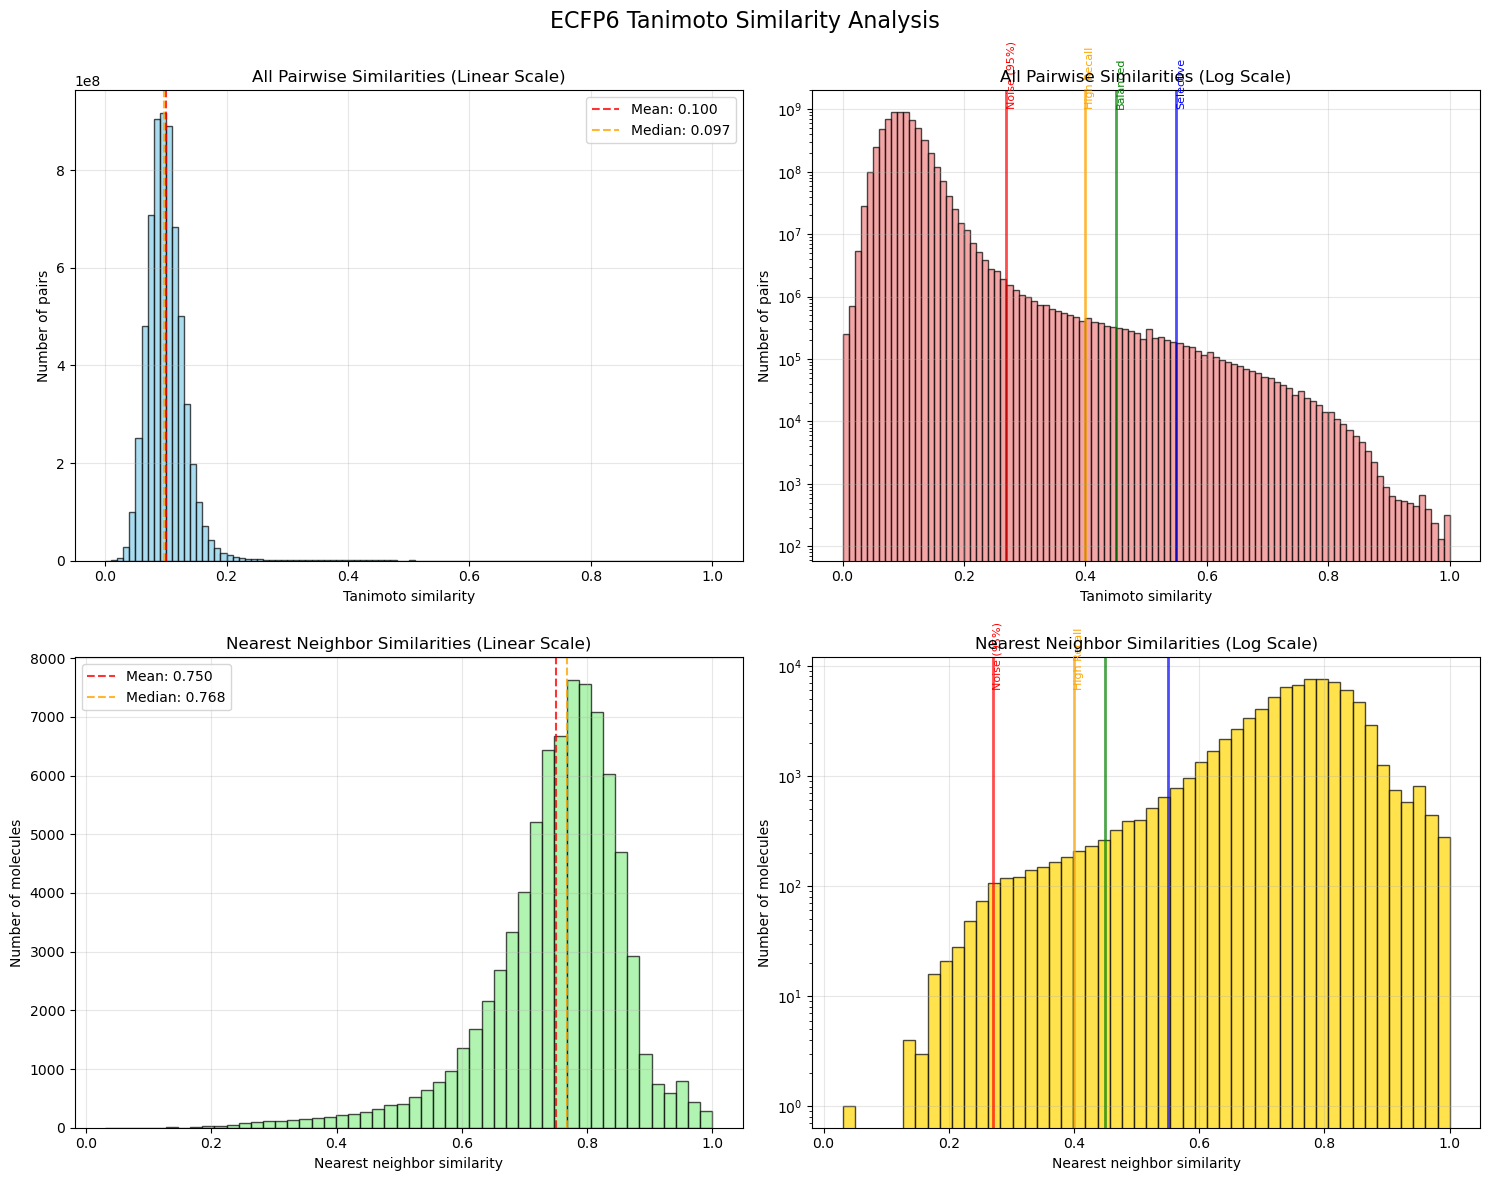


SIMILARITY DISTRIBUTION ANALYSIS

ALL PAIRWISE SIMILARITIES:
  Total pairs: 6,318,898,572
  Mean similarity: 0.1003
  Median similarity: 0.0971
  Std deviation: 0.0330
  Min similarity: 0.0000
  Max similarity: 1.0000
  Percentiles:
     5%: 0.0578
    10%: 0.0657
    25%: 0.0800
    75%: 0.1161
    90%: 0.1360
    95%: 0.1503
    99%: 0.1920

NEAREST NEIGHBOR SIMILARITIES:
  Total molecules: 79,492
  Mean NN similarity: 0.7503
  Median NN similarity: 0.7681
  Std deviation: 0.1089
  Min NN similarity: 0.0303
  Max NN similarity: 1.0000

THRESHOLD ANALYSIS:
  Compounds above noise level (≥0.27): 79,264 (99.7%)
  Compounds with high similarity NN (≥0.40): 78,315 (98.5%)
  Compounds with very high similarity NN (≥0.55): 75,517 (95.0%)

DATASET DIVERSITY INSIGHTS:
  Unique/isolated compounds (NN < 0.27): 228 (0.3%)
  Moderately similar compounds (0.27 ≤ NN < 0.55): 3,747 (4.7%)
  Highly similar compounds (NN ≥ 0.55): 75,517 (95.0%)
  → Dataset contains many similar compounds (potential f

In [6]:
# Similarity Distribution Analysis with Log Scale and Nearest Neighbors

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator





df = pd.read_csv("chembl_pretraining.csv")
smiles_column = "smiles"

df["mol"] = df[smiles_column].apply(Chem.MolFromSmiles)

df = df[df["mol"].notna()].reset_index(drop=True)

generator = GetMorganGenerator(radius=3, fpSize=2048)
df["ecfp6"] = df["mol"].apply(generator.GetFingerprint)




# Reload the similarity matrix
n = len(df)
sim_matrix = np.memmap("tanimoto_sim_matrix.dat", dtype="float32", mode="r", shape=(n, n))

print(f"Loaded similarity matrix for {n} compounds")
print(f"Matrix shape: {sim_matrix.shape}")

# 1. All pairwise similarities (off-diagonal) 
print("Computing off-diagonal similarities...")
mask = ~np.eye(n, dtype=bool)
sims = sim_matrix[mask]
print(f"Total pairwise similarities: {len(sims):,}")

# 2. Nearest neighbor similarities (max similarity for each molecule, excluding self)
print("Computing nearest neighbor similarities...")
nearest_neighbor_sims = []
for i in range(n):
    # Get similarities for molecule i, exclude self-similarity
    row_sims = sim_matrix[i, :]
    row_sims_no_self = np.concatenate([row_sims[:i], row_sims[i+1:]])
    nearest_neighbor_sims.append(np.max(row_sims_no_self))
    
    if (i + 1) % 1000 == 0:
        print(f"  Processed {i + 1}/{n} molecules")

nearest_neighbor_sims = np.array(nearest_neighbor_sims)

# Create comprehensive plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ECFP6 Tanimoto Similarity Analysis', fontsize=16)

# 1. All pairwise similarities - Linear scale
ax1 = axes[0, 0]
ax1.hist(sims, bins=100, alpha=0.7, edgecolor='black', color='skyblue')
ax1.set_xlabel("Tanimoto similarity")
ax1.set_ylabel("Number of pairs")
ax1.set_title("All Pairwise Similarities (Linear Scale)")
ax1.grid(True, alpha=0.3)

# Add some statistics
ax1.axvline(np.mean(sims), color='red', linestyle='--', alpha=0.8, label=f'Mean: {np.mean(sims):.3f}')
ax1.axvline(np.median(sims), color='orange', linestyle='--', alpha=0.8, label=f'Median: {np.median(sims):.3f}')
ax1.legend()

# 2. All pairwise similarities - Log scale
ax2 = axes[0, 1]
ax2.hist(sims, bins=100, alpha=0.7, edgecolor='black', color='lightcoral')
ax2.set_xlabel("Tanimoto similarity")
ax2.set_ylabel("Number of pairs")
ax2.set_title("All Pairwise Similarities (Log Scale)")
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

# Add threshold lines based on RDKit blog post
thresholds = {'Noise (95%)': 0.27, 'High Recall': 0.40, 'Balanced': 0.45, 'Selective': 0.55}
colors = ['red', 'orange', 'green', 'blue']
for i, (label, threshold) in enumerate(thresholds.items()):
    ax2.axvline(threshold, color=colors[i], linestyle='-', alpha=0.7, linewidth=2)
    ax2.text(threshold, ax2.get_ylim()[1]*0.5, label, rotation=90, 
            verticalalignment='bottom', fontsize=8, color=colors[i])

# 3. Nearest neighbor similarities - Linear scale  
ax3 = axes[1, 0]
ax3.hist(nearest_neighbor_sims, bins=50, alpha=0.7, edgecolor='black', color='lightgreen')
ax3.set_xlabel("Nearest neighbor similarity")
ax3.set_ylabel("Number of molecules")
ax3.set_title("Nearest Neighbor Similarities (Linear Scale)")
ax3.grid(True, alpha=0.3)

# Add statistics
ax3.axvline(np.mean(nearest_neighbor_sims), color='red', linestyle='--', alpha=0.8, 
           label=f'Mean: {np.mean(nearest_neighbor_sims):.3f}')
ax3.axvline(np.median(nearest_neighbor_sims), color='orange', linestyle='--', alpha=0.8, 
           label=f'Median: {np.median(nearest_neighbor_sims):.3f}')
ax3.legend()

# 4. Nearest neighbor similarities - Log scale
ax4 = axes[1, 1]
ax4.hist(nearest_neighbor_sims, bins=50, alpha=0.7, edgecolor='black', color='gold')
ax4.set_xlabel("Nearest neighbor similarity")
ax4.set_ylabel("Number of molecules")
ax4.set_title("Nearest Neighbor Similarities (Log Scale)")
ax4.set_yscale('log')
ax4.grid(True, alpha=0.3)

# Add threshold lines
for i, (label, threshold) in enumerate(thresholds.items()):
    ax4.axvline(threshold, color=colors[i], linestyle='-', alpha=0.7, linewidth=2)
    if i < 2:  # Only label first two to avoid crowding
        ax4.text(threshold, ax4.get_ylim()[1]*0.5, label, rotation=90, 
                verticalalignment='bottom', fontsize=8, color=colors[i])

plt.tight_layout()
plt.show()

# Print comprehensive statistics
print("\n" + "="*60)
print("SIMILARITY DISTRIBUTION ANALYSIS")
print("="*60)

print(f"\nALL PAIRWISE SIMILARITIES:")
print(f"  Total pairs: {len(sims):,}")
print(f"  Mean similarity: {np.mean(sims):.4f}")
print(f"  Median similarity: {np.median(sims):.4f}")
print(f"  Std deviation: {np.std(sims):.4f}")
print(f"  Min similarity: {np.min(sims):.4f}")
print(f"  Max similarity: {np.max(sims):.4f}")

# Percentiles
percentiles = [5, 10, 25, 75, 90, 95, 99]
print(f"  Percentiles:")
for p in percentiles:
    print(f"    {p:2d}%: {np.percentile(sims, p):.4f}")

print(f"\nNEAREST NEIGHBOR SIMILARITIES:")
print(f"  Total molecules: {len(nearest_neighbor_sims):,}")
print(f"  Mean NN similarity: {np.mean(nearest_neighbor_sims):.4f}")
print(f"  Median NN similarity: {np.median(nearest_neighbor_sims):.4f}")
print(f"  Std deviation: {np.std(nearest_neighbor_sims):.4f}")
print(f"  Min NN similarity: {np.min(nearest_neighbor_sims):.4f}")
print(f"  Max NN similarity: {np.max(nearest_neighbor_sims):.4f}")

# Threshold analysis
print(f"\nTHRESHOLD ANALYSIS:")
print(f"  Compounds above noise level (≥0.27): {np.sum(nearest_neighbor_sims >= 0.27):,} ({np.sum(nearest_neighbor_sims >= 0.27)/len(nearest_neighbor_sims)*100:.1f}%)")
print(f"  Compounds with high similarity NN (≥0.40): {np.sum(nearest_neighbor_sims >= 0.40):,} ({np.sum(nearest_neighbor_sims >= 0.40)/len(nearest_neighbor_sims)*100:.1f}%)")
print(f"  Compounds with very high similarity NN (≥0.55): {np.sum(nearest_neighbor_sims >= 0.55):,} ({np.sum(nearest_neighbor_sims >= 0.55)/len(nearest_neighbor_sims)*100:.1f}%)")

# Dataset diversity insights
print(f"\nDATASET DIVERSITY INSIGHTS:")
low_similarity = np.sum(nearest_neighbor_sims < 0.27)
medium_similarity = np.sum((nearest_neighbor_sims >= 0.27) & (nearest_neighbor_sims < 0.55))
high_similarity = np.sum(nearest_neighbor_sims >= 0.55)

print(f"  Unique/isolated compounds (NN < 0.27): {low_similarity:,} ({low_similarity/len(nearest_neighbor_sims)*100:.1f}%)")
print(f"  Moderately similar compounds (0.27 ≤ NN < 0.55): {medium_similarity:,} ({medium_similarity/len(nearest_neighbor_sims)*100:.1f}%)")
print(f"  Highly similar compounds (NN ≥ 0.55): {high_similarity:,} ({high_similarity/len(nearest_neighbor_sims)*100:.1f}%)")

if high_similarity > len(nearest_neighbor_sims) * 0.1:
    print(f"  → Dataset contains many similar compounds (potential for redundancy)")
elif low_similarity > len(nearest_neighbor_sims) * 0.5:
    print(f"  → Dataset is highly diverse (many unique structures)")
else:
    print(f"  → Dataset has balanced diversity")

print("="*60)

# Optional: Save nearest neighbor similarities for further analysis
print(f"\nSaving nearest neighbor similarities to file...")
np.save("nearest_neighbor_similarities.npy", nearest_neighbor_sims)
print(f"Saved to: nearest_neighbor_similarities.npy")